In [3]:
import numpy as np
from astropy.table import Table
import thecannon as tc
import matplotlib.pyplot as p
# from mpi4py import MPI
# import multiprocess as mp

# comm = MPI.COMM_WORLD
# rank = comm.Get_rank()

## Let's start by training and testing only on giants with modest reddening (logg<3, Teff<5500K, A_v < 1)

Currently training on mock BP RP spectra from Maddie.  Ultimately, we will want to train directly on the Hermite coefficient matrices to save time.

In [4]:
#paths
table_path = '/Users/catherinemanea/Documents/BP_RP/apogee_bprp_params/apogee_bprp_params/'
spec_path = '/Users/catherinemanea/Documents/BP_RP/apogee_bprp_params/apogee_bprp_params/' #assumes spec are in directory 'apogee' inside this path
fig_path = '/Users/catherinemanea/Documents/BP_RP/apogee_bprp_params/apogee_bprp_params/'

Load in labels:

In [5]:
t = Table.read(table_path+'synth_apogee_0.fits')
t = t[t['synth']]

Load in spectra:

In [10]:
#loading in spec with max normalization
size = len(t) #adjust if you only want to play with subset of data

for i in range(size):
    if i%1000 == 0:
        print(str(np.round(100*i/size, 2))+'%', end='    \r')
    Teff = t['Teff'][i] ; logg = t['logg'][i] ; feh = t['feh'][i] ;  a = t['A_v'][i] ; s = t['SNR'][i]
    filename = '%s_g%s_f%s_a%s_n%s.txt'%(str(Teff),str(logg),str(feh),str(a),str(s))
    try:
        w, fbp, ebp = np.loadtxt(spec_path+'apogee/Bp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
        wr, frp, erp = np.loadtxt(spec_path+'apogee/Rp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
       
    except:  
        try:
            formatter = "{0:.12g}"
            Teff2 = formatter.format(Teff)
            logg2 = formatter.format(logg)
            feh2 = formatter.format(feh)
            s2 = formatter.format(s)
            a2 = formatter.format(a)
            filename = '%s_g%s_f%s_a%s_n%s.txt'%(str(Teff2),str(logg2),str(feh2),str(a2),str(s2))
            w, fbp, ebp = np.loadtxt(spec_path+'apogee/Bp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
            wr, frp, erp = np.loadtxt(spec_path+'apogee/Rp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
            
        except:
            try:
                formatter = "{0:.12g}"
                logg2 = formatter.format(logg)
                feh2 = formatter.format(feh)
                s2 = formatter.format(s)
                a2 = formatter.format(a)
                filename = '%s_g%s_f%s_a%s_n%s.txt'%(str(Teff),str(logg2),str(feh2),str(a2),str(s2))
                w, fbp, ebp = np.loadtxt(spec_path+'apogee/Bp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
                wr, frp, erp = np.loadtxt(spec_path+'apogee/Rp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
                
            except:
                formatter = "{0:.12g}"
                Teff2 = formatter.format(Teff)
                logg2 = formatter.format(logg)
                feh2 = formatter.format(feh)
                a2 = formatter.format(a)
                s = "{0:.1f}".format(s)
                filename = '%s_g%s_f%s_a%s_n%s.txt'%(str(Teff2),str(logg2),str(feh2),str(a2),str(s))
                w, fbp, ebp = np.loadtxt(spec_path+'apogee/Bp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)
                wr, frp, erp = np.loadtxt(spec_path+'apogee/Rp_'+filename,usecols=(0,1,2),skiprows=1,unpack=True)

    w = w[~np.isnan(ebp)]
    wr = wr[~np.isnan(erp)]
    fbp = fbp[~np.isnan(ebp)]
    ebp = ebp[~np.isnan(ebp)]
    frp = frp[~np.isnan(erp)]
    erp = erp[~np.isnan(erp)]
    
    if i == 0:
        xs = np.zeros((len(t[:size]),len(np.concatenate([fbp,frp]))))
        bps = np.zeros((len(t[:size]),len(fbp)))
        rps = np.zeros((len(t[:size]),len(frp)))
        xerrs = np.zeros((len(t[:size]),len(np.concatenate([fbp,frp]))))
        standard_errs = np.zeros((len(t[:size]),len(np.concatenate([fbp,frp]))))
    
    f = np.concatenate([fbp,frp])
    errs = 1.0/np.sqrt(np.concatenate([ebp,erp])/np.max(f))
    xs[i,:] = f/np.max(f)
    bps[i,:] = fbp/np.max(fbp)
    rps[i,:] = frp/np.max(frp)
    xerrs[i,:] = errs
    standard_errs[i,:] = np.concatenate([ebp,erp])/np.max(f)
    wf = np.concatenate([w,wr])
    

Define subset of data for training and testing (giants):

In [11]:
subset = np.where((t['Teff'] < 5500) & (t['logg'] < 3) & (t['A_v'] < 1))
t_subset = t[subset]
xs_subset = xs[subset]
xerrs_subset = xerrs[subset]

Separate training and testing sets, reassign NaN and inf values:

In [16]:
#making training and testing sets
# train_inds = np.random.choice(range(len(t)),int(.6*len(t)),replace=False)
# test_inds = np.array(list(set(range(len(t)))- set(train_inds)),dtype='int')
print(len(t), len(t[subset]))

np.random.seed(777) # For reproducibility.
q = np.random.randint(0, 10, len(t_subset)) % 10
validate_set = np.where((q<=2))[0]
train_set = np.where((q>2))[0]
train_inds = train_set
test_inds = validate_set

train_xs = xs_subset[train_inds]
train_errs = xerrs_subset[train_inds]
bad = np.where(np.isnan(train_xs))
train_xs[bad] = 0.0000001
bad = np.where(np.isnan(train_errs))
train_errs[bad] = 0.0000001
bad = np.where(train_xs==np.inf)
train_xs[bad] = 1e6
bad = np.where(train_errs==np.inf)
train_errs[bad] = 1e6

test_xs = xs_subset[test_inds]
test_errs = xerrs_subset[test_inds]
bad = np.where(np.isnan(test_xs))
test_xs[bad] = 0.0000001
bad = np.where(np.isnan(test_errs))
test_errs[bad] = 0.0000001
bad = np.where(test_xs==np.inf)
test_xs[bad] = 1e6
bad = np.where(test_errs==np.inf)
test_errs[bad] = 1e6

train_t = t_subset[train_inds]
test_t = t_subset[test_inds]

print(len(train_t), len(test_t))

62074 9069
6333 2736


Plot some spectra just to see what they look like:

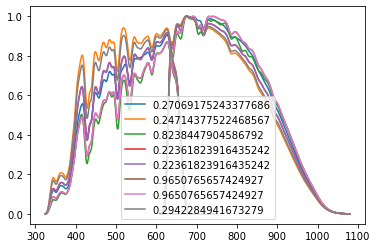

In [13]:
teffs = t_subset['Teff']
loggs = t_subset['logg']
fehs = t_subset['feh']
avs = t_subset['A_v']
snrs = t_subset['SNR']

#plot a few spectra
p.figure()
N=1
for i in range(8):
    p.plot(wf, xs_subset[i], label=t_subset['A_v'][i])
p.legend()
p.show()

Specify vectorizer, set up and train the model:

In [17]:
# Specify the vectorizer.
vectorizer = tc.vectorizer.PolynomialVectorizer(("Teff", "logg", "feh", "A_v"), 2)
# set up model
model = tc.CannonModel(train_t, train_xs, train_errs,
                       vectorizer=vectorizer, dispersion=wf)


# Train the model!
model.train()



2022-05-30 17:43:54,649 [INFO] Training 4-label CannonModel with 6333 stars and 897 pixels/star
stty: 2022-05-30 17:43:54,674 [DEBUG] Couldn't get screen size. Progressbar may look odd.


[====                                                                                                ]   4% (34/897)                          

stdin isn't a terminal


[================================================================================================================] 100% (4s)                               


(array([[ 5.98356670e-04,  5.53200530e-04,  3.02110807e-04, ...,
         -4.48886342e-04,  1.37923439e-04,  5.53540003e-05],
        [ 1.16588329e-03,  1.07178584e-03,  5.84947277e-04, ...,
         -8.66613436e-04,  2.61755550e-04,  1.03953503e-04],
        [ 2.14233063e-03,  1.95772756e-03,  1.06783594e-03, ...,
         -1.57669165e-03,  4.68023732e-04,  1.83735200e-04],
        ...,
        [ 3.53676167e-04, -1.13406576e-04, -2.17232030e-06, ...,
         -7.99891026e-06,  2.43444311e-06,  1.73971617e-05],
        [ 3.06881316e-04, -9.85355613e-05, -1.86084239e-06, ...,
         -6.90915550e-06,  2.16565228e-06,  1.51113363e-05],
        [ 2.63734385e-04, -8.47741720e-05, -1.59792529e-06, ...,
         -6.00210393e-06,  1.94716725e-06,  1.29912599e-05]]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 

Test the model:

In [18]:
#infer for train
test_labels, cov, metadata = model.test(test_xs, test_errs)


#fig_comparison = tc.plot.one_to_one(model, test_labels, latex_label_names=[r"T_{\rm eff}",r"\log{g}",r"[{\rm Fe}/{\rm H}]",r"{\rm A_V}"])
#fig_comparison.savefig(fig_path+"one-to-one.png", dpi=300)

stty: stdin isn't a terminal
2022-05-30 17:46:08,248 [DEBUG] Couldn't get screen size. Progressbar may look odd.
2022-05-30 17:46:08,251 [INFO] Running test step on 2736 spectra


[=====================================================================================================] 100% (32s)                                


Plot difference between true and inferred values:

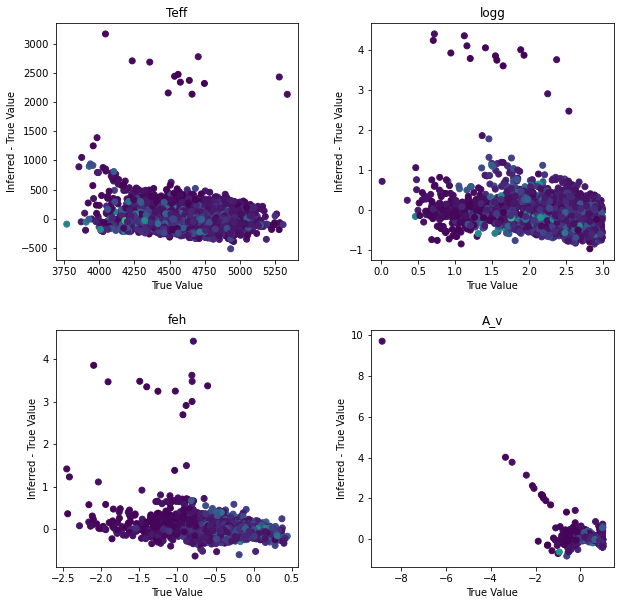

In [19]:
fig, axs = p.subplots(2,2,figsize=(10,10))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i, param in enumerate(['Teff', 'logg', 'feh', 'A_v']):
    ax = np.ravel(axs)[i]
    ax.scatter(t_subset[param][test_inds],test_labels[:,i] - t_subset[param][test_inds],c=t_subset['SNR'][test_inds])
    ax.set_title(param)
    ax.set_xlabel("True Value")
    ax.set_ylabel("Inferred - True Value")

Histograms of inferred vs true values

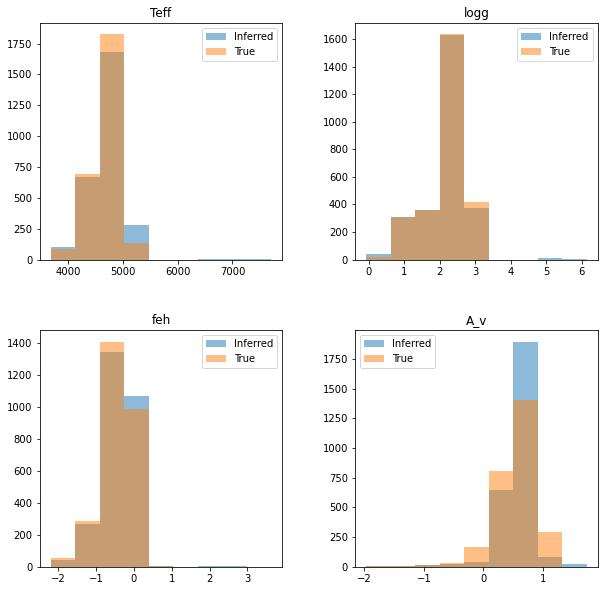

In [21]:
fig, axs = p.subplots(2,2,figsize=(10,10))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i, param in enumerate(['Teff', 'logg', 'feh', 'A_v']):
    ax = np.ravel(axs)[i]
    ax.hist(test_labels[:,i], alpha=.5, label='Inferred', bins=np.linspace(np.min(test_labels[:,i]), np.max(test_labels[:,i]), 10))
    ax.hist(t_subset[param][test_inds], alpha=.5, label='True', bins=np.linspace(np.min(test_labels[:,i]), np.max(test_labels[:,i]), 10))
    ax.set_title(param)
    ax.legend()

In [22]:
print(np.mean(test_labels[:,0]))
print(np.mean(np.abs(test_labels[:,0]-t_subset['Teff'][test_inds])))
print(np.mean(np.abs(test_labels[:,1]-t_subset['logg'][test_inds])))
print(np.mean(t_subset['Teff'][test_inds]))

4713.514115503945
133.1570589247056
0.23250657097173905
4673.8448497928375


In [14]:
print(np.min(t_subset['Teff'][test_inds]), np.max(t_subset['Teff'][test_inds]))
print(np.min(t_subset['Teff'][train_inds]), np.max(t_subset['Teff'][train_inds]))

4500.07275390625 6499.94677734375
4500.07666015625 6499.4990234375


In [24]:
# def func1():
#     print('func1: starting')
#     for i in xrange(10000000): pass
#     print('func1: finishing')

# def func2():
#     print('func2: starting')
#     for i in xrange(10000000): pass
#     print('func2: finishing')

# p1 = Process(target=func1)
# p1.start()
# p2 = Process(target=func2)
# p2.start()
# p1.join()
# p2.join()

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/envs/p38/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/anaconda3/envs/p38/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'func1' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/envs/p38/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/anaconda3/envs/p38/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'func2' on <module '__main__' (built-in)>
